In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
from dataset import SyntheticDataset
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

In [157]:
from dataset import SyntheticDatasetType
exp_label = 'snr10'

dataset_type = SyntheticDatasetType.SNR10
result_path = os.path.join(config.RESULTS_PATH, 'syntheticData')

# Image to RGB

In [158]:
from dataset import SyntheticDataset, SyntheticDatasetType
dataset = SyntheticDataset(config.Synthetic_PATH, type=dataset_type ,transform=None)

# matlab_data = {
#     'X': dataset.image(),
#     'n_endmembers': dataset.n_endmembers,
#     'nRow': dataset.n_row,
#     'nCol': dataset.n_col,
#     'nBand': dataset.n_bands
# }

# sio.savemat(os.path.join(result_path, 'matlab/snr10/input.mat'), matlab_data)

In [159]:
jasper_wv = np.linspace(380, 2500, 224, dtype=int) # 224 bands from 380 to 2500 nm

data = sio.loadmat(os.path.join(config.JasperRidge_PATH, 'jasperRidge2_R198.mat'))
selected_bands = data['SlectBands'].squeeze()
selected_jasper_wv = jasper_wv[selected_bands].tolist()

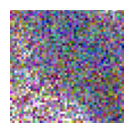

198 (2500, 198)


In [160]:
from HSI2RGB import HSI2RGB

# Use the D65 illuminant
illuminant = 65

# Do minor thresholding
threshold = 0.02
X = dataset.image()
(ydim, xdim, zdim) = X.shape

# Reorder data so that each column holds the spectra of of one pixel
HSI_data = np.reshape(X, [-1,zdim])
rgb = HSI2RGB(selected_jasper_wv, HSI_data, xdim, ydim, illuminant, threshold)

fig = plt.figure(figsize=(7,5))
plt.subplot(3,4,1)
plt.imshow(rgb)
plt.axis('off')
plt.show(fig)

print(len(selected_jasper_wv), HSI_data.shape)

# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/synthetic_rgb.png'.format(exp_label)), dpi=300, bbox_inches='tight')

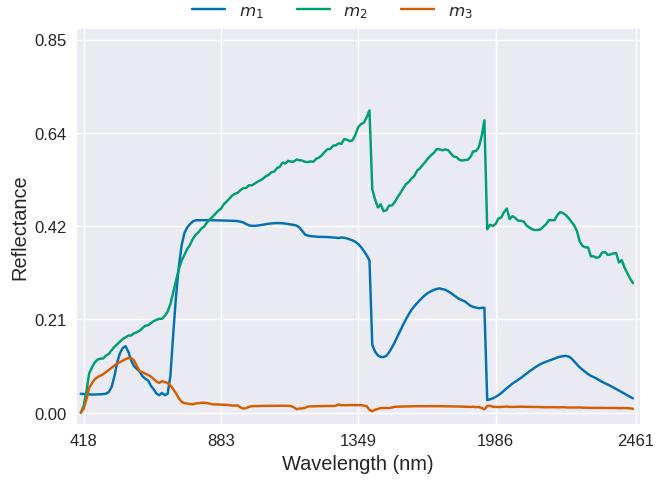

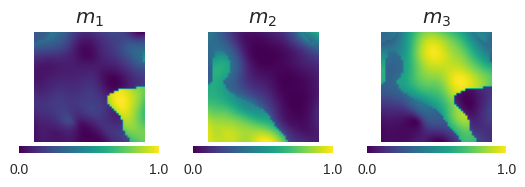

In [161]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), np.array(selected_jasper_wv), ticks_range=(0, .85))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/M_ref.pdf'.format(exp_label)), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/A_ref.pdf'.format(exp_label)), dpi=300, bbox_inches='tight')

# Endmember estimation

In [162]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return endmembers[e_idx], e_idx, sad_result

## VCA

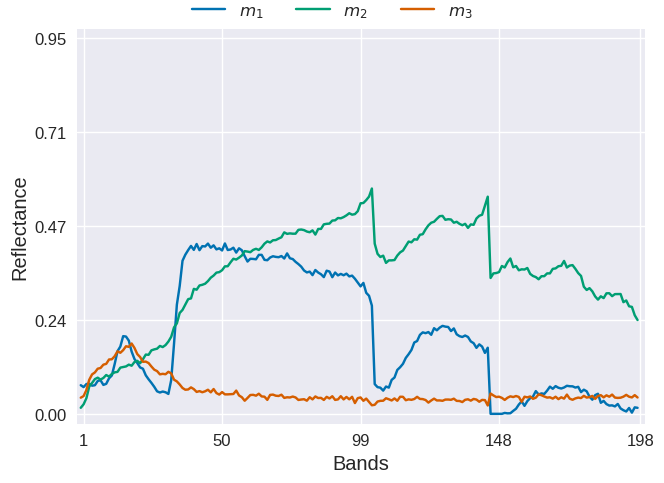

In [163]:
from HySpecLab.eea import VCA
_X = X.reshape(-1, X.shape[-1])
n_endmembers = 3
vca = VCA(n_endmembers, snr_input=30, random_state=25)
vca.fit(_X)
endmembers = torch.from_numpy(vca.endmembers()).float()

vca_endmember_init, _, _ = sort_endmember(endmembers, dataset.endmembers())
vca_logit_endmember_init = torch.log((vca_endmember_init / (1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, ticks_range=(0, .95))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/M_vca.pdf'.format(exp_label)), bbox_inches='tight')

## N-FINDR

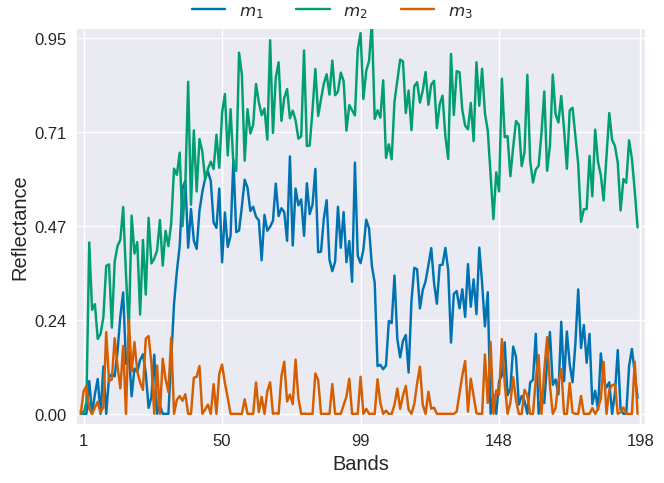

In [164]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(X, n_endmembers)).float()

nfindr_endmember_init, _, _ = sort_endmember(endmember, dataset.endmembers())
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init / (1-nfindr_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, ticks_range=(0, .95))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/M_nfindr.pdf'.format(exp_label)), bbox_inches='tight')

## Plot

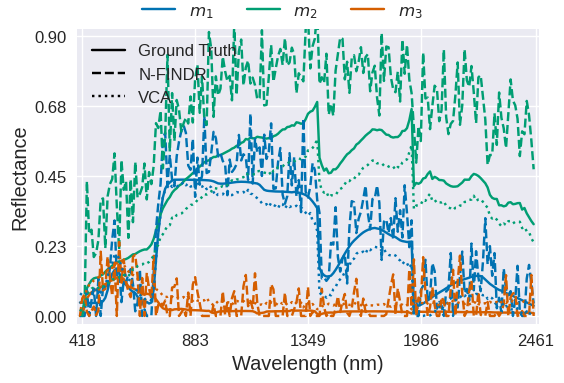

In [165]:
fig = plot_endmembers(dataset.endmembers(), np.array(selected_jasper_wv), ticks_range=(0, .9), figsize=(6,4), endmember_estimation=[nfindr_endmember_init, vca_endmember_init], ee_labels=['Ground Truth', 'N-FINDR', 'VCA'])
plt.show(fig)
# fig.savefig(os.path.join(result_path,  'clhu/{}/imgs/M_estimation.pdf'.format(exp_label)), bbox_inches='tight')

## Select endmembers initialization

In [166]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

In [167]:
# endmembers_dict = {'NFINDR': endmember_init.numpy(), 'VCA': vca_endmember_init.numpy()}

# sio.savemat(os.path.join(result_path, 'matlab/{}/endmember_estimation.mat'.format(exp_label)), endmembers_dict)

In [168]:
import numpy as np
import torch

from torch.nn import Parameter
from torch.nn import functional as F


class GaussianFeatureSelector(nn.Module):
    def __init__(self, in_features: int, sigma:float=.5) -> None:
        super(GaussianFeatureSelector, self).__init__()
        self.in_features = in_features
        self.sigma = sigma
        self.mu = Parameter(torch.ones(in_features)*.5) 

    def forward(self, x):
        eps = torch.normal(0, torch.ones_like(self.mu))
        prob = self.mu + (self.sigma * eps * self.training) 
        z = prob
        # z = 1 - prob
        gate = F.hardtanh(z, 0, 1)
        result = gate * x

        return result
        

    def _guassian_cdf(self, mu:torch.Tensor, sigma:float) -> torch.Tensor:
        r''' 
            Guassian CDF
            
            Based on: https://stackoverflow.com/questions/809362/how-to-calculate-cumulative-normal-distribution

            Parameters
            ----------
            mu: torch.Tensor, shape (in_features,)
                The mean of the Guassian
            
            sigma: float
                The standard deviation of the Guassian
        '''
        return .5 * (1 + torch.erf(mu / (sigma*np.sqrt(2))))

    def regularize(self):
        r'''
            The expected regularization is the sum of the probabilities 
            that the gates are active
        '''
        return torch.mean(self._guassian_cdf(self.mu, self.sigma))
        # return torch.mean(self._guassian_cdf(1-self.mu, self.sigma))

    def variational_parameter(self, logit=True):
        return self.mu if logit else F.hardtanh(self.mu, 0, 1)
    
    def __repr__(self):
        return f'GaussianFeatureSelector(in_features={self.in_features}, sigma={self.sigma:.2f})'

In [169]:
import torch 
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

from collections import deque
from itertools import islice

def lmm(A: torch.Tensor, E: torch.Tensor) -> torch.Tensor:
    '''
        Linear Mixing Model, linear combination of endmembers.

        Args:
        -----
            A: Tensor, shape (bs, n_endmembers)
                Abundance matrix of the linear mixing model.
            E: Tensor, shape (n_endmembers, n_bands)
                Endmembers.
    '''
    bs, _ = A.shape
    return torch.bmm(A.unsqueeze(1), E.unsqueeze(0).expand(bs, -1, -1)).squeeze()

## General
def slide(iterable, size):
    '''
        Iterate through iterable using a sliding window of several elements.
        Important: It is a generator!.
        
        Creates an iterable where each element is a tuple of `size`
        consecutive elements from `iterable`, advancing by 1 element each
        time. For example:
        >>> list(sliding_window_iter([1, 2, 3, 4], 2))
        [(1, 2), (2, 3), (3, 4)]
        
        source: https://codereview.stackexchange.com/questions/239352/sliding-window-iteration-in-python
    '''
    iterable = iter(iterable)
    window = deque(islice(iterable, size), maxlen=size)
    for item in iterable:
        yield tuple(window)
        window.append(item)
    if window:  
        # needed because if iterable was already empty before the `for`,
        # then the window would be yielded twice.
        yield tuple(window)

class ContrastiveUnmixing(nn.Module):
    def __init__(self, n_bands, n_endmembers, encode_layers=[512, 128, 32], endmember_init=None, sparsity=5) -> None:
        super(ContrastiveUnmixing, self).__init__()      
        encode_layers = [n_bands] + encode_layers
        self.n_endmembers = n_endmembers
        # Encoder
        encoder = []
        for idx, test in enumerate(slide(encode_layers, 2)):
            encoder.append(self.__encode_layer(*test, dropout=True if idx < len(encode_layers)-2 else False))
        self.encoder = nn.Sequential(*encoder)

        # Endmember bank
        self.ebk = Parameter(torch.randn(n_endmembers, n_bands))
        if endmember_init is not None:
            self.ebk.data = endmember_init

        self.sparse = sparsity
        self.sparse_gate = GaussianFeatureSelector(1, sigma=.5)
        
        self.projection = nn.Linear(encode_layers[-1], n_bands, bias=False)
        # Projection layer
        # self.projection = nn.Sequential(
        #     nn.Linear(encode_layers[-1], 64, bias=True),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(),
        #     nn.Linear(64, n_bands, bias=False),
        #     # nn.BatchNorm1d(n_bands, affine=True),
        # )
        
        # Abundance matrix
        self.A = None

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        r0 = self.projection( self.encoder(input) )

        self.A = self.__similarity(r0)
        return lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))

    def __encode_layer(self, in_features, out_features, dropout=False):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            *[nn.ReLU(), nn.Dropout(0.5)] if dropout else [nn.Identity()]
        )

    def __similarity(self, X: torch.Tensor) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.         
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(self.ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        v = (cos*.5) + .5
        # return torch.exp(self.sparse_gate(self.sparse))*torch.log(v/ (1-v))
        return torch.pow(self.n_endmembers, self.sparse_gate(self.sparse))*torch.log(v/ (1-v))

In [170]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss
from torch.utils.data import Dataset, DataLoader
from torch import sigmoid, nn
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss
from torch.utils.data import Dataset, DataLoader
from torch import sigmoid, nn
from tqdm import tqdm
import torch

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3, similarity_weight=1, sparse_weight=1e-1):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = UnmixingLoss() 
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    scaler = torch.cuda.amp.GradScaler()

    for _ in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + similarity_weight*similarity_reg(model.ebk) +  sparse_weight*model.sparse_gate.regularize()
            epoch_loss += loss.detach().item()

            # loss.backward()
            # optimizer.step()


            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

# Training

In [183]:
# from utils import train 
# from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sparsity=0)
# train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=5e-3)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, sparse_weight=1)

  0%|          | 0/50 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 50/50 [00:19<00:00,  2.53epoch/s, tls=0.5598]


In [184]:
model.sparse_gate.mu

Parameter containing:
tensor([-1.1056], device='cuda:0', requires_grad=True)

## Saving model

In [185]:
# torch.save(model.state_dict(), os.path.join(result_path, 'clhu/{}/weights/clhu_{}.pth'.format(exp_label, endmember_init_method)))

## Testing model

In [186]:
# from HySpecLab.unmixing import ContrastiveUnmixing

# load model
# model = ContrastiveUnmixing(dataset.n_bands, dataset.n_endmembers)

# model.load_state_dict(torch.load(os.path.join(result_path, 'clhu/{}/weights/clhu_{}.pth'.format(exp_label, endmember_init_method))))
model = model.eval()

In [187]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=dataset.n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], dataset.n_endmembers)
similarity_reg = SimilarityLoss(dataset.n_endmembers, temperature=.1, reduction='mean')

In [188]:
from torch import sigmoid
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(model.ebk).cpu())
        #  similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.5138) tensor(0.6271) tensor(41.9138) tensor(0.0030)


In [189]:
volume_reg(endmember_init), similarity_reg(logit_endmember_init)

(tensor(19.2263), tensor(0.0156))

## Figures and metrics

Endmember estimation, compared with N-FINDR

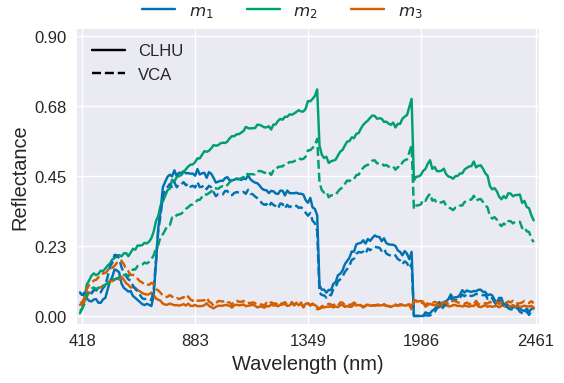

In [190]:
ebk = sigmoid(model.ebk).detach().cpu()
if endmember_init_method == 'vca':
    label = 'VCA'
else:
    label = 'N-FINDR'
fig = plot_endmembers(ebk, np.array(selected_jasper_wv), ticks_range=(0, .9), figsize=(6,4), endmember_estimation=[endmember_init], ee_labels=['CLHU',label])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/{}/M_clhu_estimation.pdf'.format(exp_label, endmember_init_method)), bbox_inches='tight')

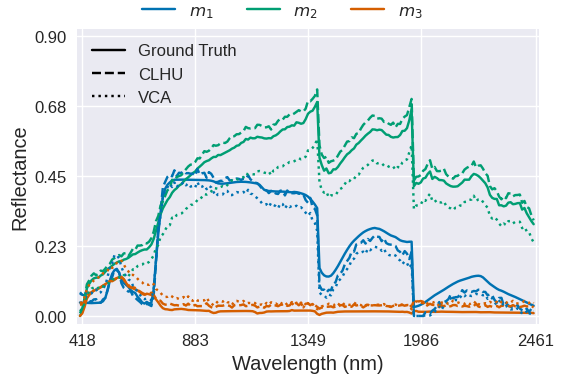

In [191]:
ebk = sigmoid(model.ebk).detach().cpu()
if endmember_init_method == 'vca':
    label = 'VCA'
else:
    label = 'N-FINDR'
fig = plot_endmembers(dataset.endmembers(), np.array(selected_jasper_wv), ticks_range=(0, .9), figsize=(6,4), endmember_estimation=[ebk, endmember_init], ee_labels=['Ground Truth','CLHU',label])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/{}/M_clhu_estimation.pdf'.format(exp_label, endmember_init_method)), bbox_inches='tight')

Abundance Map

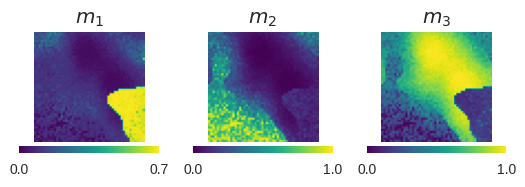

In [192]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test)
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/{}/A_clhu_estimation.pdf'.format(exp_label, endmember_init_method)),  bbox_inches='tight')

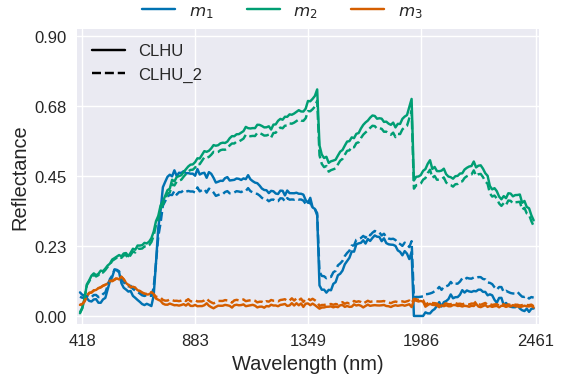

(tensor([[0.1014, 0.5412, 1.1508],
         [0.4461, 0.0107, 1.0880],
         [0.8759, 0.7573, 0.3651]]),
 0.15903647,
 tensor([[0.0504, 0.4103, 1.1048],
         [0.4377, 0.0136, 1.0854],
         [0.7290, 0.6139, 0.4942]]),
 0.18607962)

In [193]:
M = sigmoid(model.ebk).detach().cpu()
M_hat = model(M).detach().cpu()

fig = plot_endmembers(M, np.array(selected_jasper_wv), endmember_estimation=[M_hat], ee_labels=['CLHU', 'CLHU_2'], ticks_range=(0, .9), figsize=(6,4))
plt.show(fig)

sad(M, dataset.endmembers()), np.diagonal(sad(M, dataset.endmembers())).mean(), sad(M_hat, dataset.endmembers()), np.diagonal(sad(M_hat, dataset.endmembers())).mean()

RMSE_X, RMSE_A, SAD_M

In [194]:
X_true = dataset.A @ dataset.endmembers()
X_hat = model(dataset.X).detach().cpu()
A_hat = torch.softmax(model.A.detach().cpu(), dim=1)
M_hat = sigmoid(model.ebk.detach().cpu())

# _M_hat = model(M_hat).detach()

import pandas as pd
df = pd.DataFrame(columns=['Method', 'RMSE_Y', 'RMSE_A', 'SAD_M'])
df['Method'] = ['CLHU']
df['RMSE_Y'] = [rmse(X_true, X_hat, dim=None).numpy()]
df['RMSE_A'] = [rmse(dataset.A, A_hat, dim=None).numpy()]

# sad_result = sad(_M_hat, dataset.endmembers()).numpy()
sad_result = sad(M_hat, dataset.endmembers()).numpy()
df['SAD_M'] = np.diagonal(sad_result).mean()

# df.to_csv(os.path.join(result_path, 'clhu/{}/metrics_{}.csv'.format(exp_label, endmember_init_method)), index=False)
df


,Method,RMSE_Y,RMSE_A,SAD_M
0,CLHU,0.031375572,0.08197559,0.159036


In [233]:
np.diagonal(sad(M_hat, dataset.endmembers())).mean(), np.diagonal(sad(endmember_init, dataset.endmembers())).mean()
# sad(M_hat, dataset.endmembers()), sad(endmember_init, dataset.endmembers())

(0.15983975, 0.15802276)

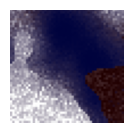

In [234]:
from HSI2RGB import HSI2RGB

# Use the D65 illuminant
illuminant = 65

# Do minor thresholding
threshold = 0.02
_X_hat = X_hat.numpy()
X_hat_img = _X_hat.reshape(dataset.n_row, dataset.n_col, dataset.n_bands, order='F')
(ydim, xdim, zdim) = X_hat_img.shape

# Reorder data so that each column holds the spectra of of one pixel
HSI_data = np.reshape(X_hat_img, [-1,zdim])
rgb = HSI2RGB(selected_jasper_wv, HSI_data, xdim, ydim, illuminant, threshold)

fig = plt.figure(figsize=(7,5))
plt.subplot(3,4,1)
plt.imshow(rgb)
plt.axis('off')
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'clhu/{}/imgs/{}/reconstruction_rgb.png'.format(exp_label,endmember_init_method)), dpi=300, bbox_inches='tight')

# ...

In [235]:
from torch import sigmoid
def test(model, dataset):
    X = dataset.X
    model.eval()
    model = model.cpu()
    
    X_true = dataset.A @ dataset.endmembers()
    with torch.no_grad():
        X_hat = model(dataset.X)
        A_hat = torch.softmax(model.A, dim=1)
        M_hat = sigmoid(model.ebk) 
    
    rmse_x = rmse(X_true, X_hat, dim=None).numpy()      
    rmse_a = rmse(dataset.A, A_hat, dim=None).numpy()
    sad_m = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
    return rmse_x.item(), rmse_a.item(), sad_m

In [236]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands

batch_rmse_x = []
batch_rmse_a = []
batch_sad_m = []
for i in range(10):
    model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
    train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=1e-2)

    rmse_x, rmse_a, sad_m = test(model, dataset)
    batch_rmse_x.append(rmse_x)
    batch_rmse_a.append(rmse_a)
    batch_sad_m.append(sad_m)

  0%|          | 0/50 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 50/50 [00:21<00:00,  2.35epoch/s, tls=0.5640]


In [237]:
# generate dataframe
import pandas as pd
df = pd.DataFrame(columns=['RMSE_X', 'RMSE_A', 'SAD_M'])
df['RMSE_X'] = batch_rmse_x
df['RMSE_A'] = batch_rmse_a
df['SAD_M'] = batch_sad_m

# extract mean and std
df['RMSE_X'].mean(), df['RMSE_X'].std(), df['RMSE_A'].mean(), df['RMSE_A'].std(), df['SAD_M'].mean(), df['SAD_M'].std()

(0.03105625733733177,
 0.0004529953552292537,
 0.07167255282402038,
 0.0019317507690964698,
 0.15859228,
 0.0015666041290387511)

In [238]:
df.to_csv(os.path.join(result_path, 'clhu/{}/metrics_{}_batch.csv'.format(exp_label, endmember_init_method)), index=False)

In [240]:
os.path.join(result_path, 'clhu/{}/metrics_{}_batch.csv'.format(exp_label, endmember_init_method))

'/media/abian/Extreme SSD/Thesis/CLHU/results/syntheticData/clhu/snr10/metrics_vca_batch.csv'

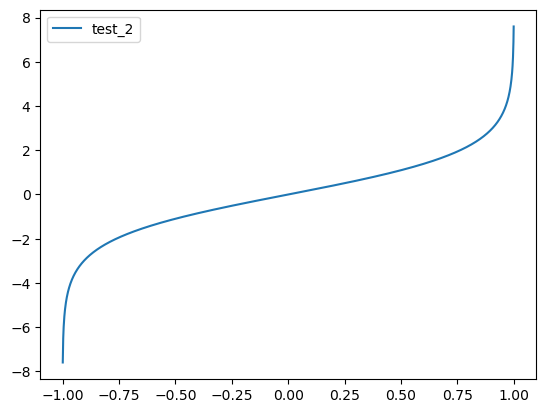

tensor([4.9999e-04, 9.9999e-04, 1.5000e-03,  ..., 9.9850e-01, 9.9900e-01,
        9.9950e-01])

In [42]:
import torch
from matplotlib import pyplot as plt
cos = torch.arange(-0.999, 1, 0.001)

from torch import softmax
test = - torch.log(1 - torch.pow(cos, 2) + 1e-8)
# test_2 = - torch.log(1 - torch.abs(cos) + 1e-8)
cos_2 = (cos * 0.5) + 0.5
test_2 = torch.log((cos_2)/(1 - cos_2 + 1e-8)) 
# test_2 = softmax(test_2, dim=0)
# test = softmax(test, dim=0)
# test_2 = softmax(test_2, dim=0)
# plt.plot(cos, test, label='test')
plt.plot(cos, test_2, label='test_2')
plt.legend()
plt.show()

cos_2


In [29]:
test_2

tensor([nan, nan, nan,  ..., nan, nan, nan])

In [24]:
(-1 * 0.5) + 0.5, (0 * 0.5) + 0.5, (1 * 0.5) + 0.5

(0.0, 0.5, 1.0)

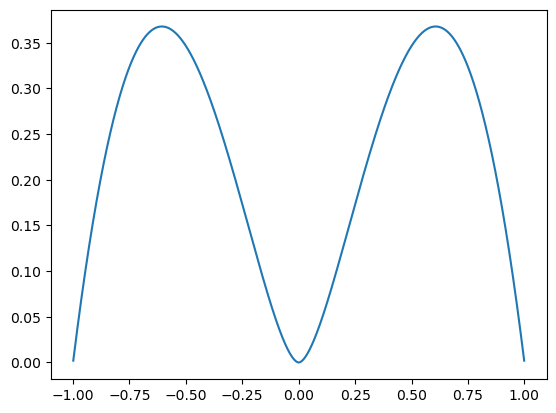

In [8]:
import torch
from matplotlib import pyplot as plt
cos = torch.arange(-0.999, 1, 0.001)

# p = 1 - torch.pow(cos, 2) + 1e-8
p = torch.pow(cos, 2) + 1e-8
test = - p * torch.log(p)
test_2 = - torch.log(p)
# test_2 = - torch.log(1 - torch.abs(cos) + 1e-8)
plt.plot(cos, test)
# plt.plot(cos, test_2)
plt.show()

In [3]:
cos = torch.tensor([1, .2, .01, .1])

cross_entropy = - torch.log(cos[1:]).sum()
cross_entropy

tensor(8.5172)

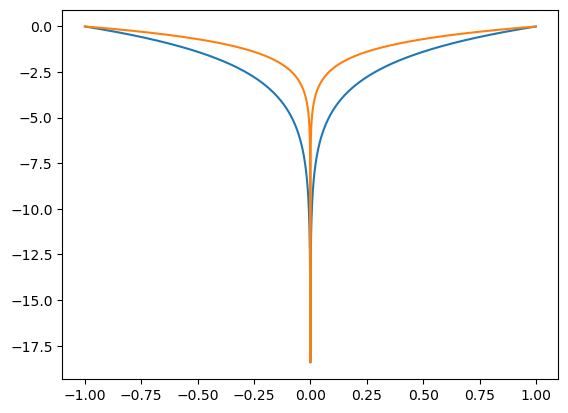

In [4]:
import torch
from matplotlib import pyplot as plt
cos = torch.arange(-0.999, 1, 0.001)


test = torch.log(torch.pow(cos, 2) + 1e-8)
test_2 = torch.log(torch.abs(cos) + 1e-8)
plt.plot(cos, test)
plt.plot(cos, test_2)
plt.show()

In [5]:
from torch.nn.functional import normalize, cross_entropy

X = vca_endmember_init
X = normalize(X, dim=1)
similarity_matrix = torch.softmax(torch.matmul(X, X.T), dim=1)/.1

labels = torch.arange(0, 3).to(X.device)
cross_entropy(similarity_matrix, labels, reduction='mean')

NameError: name 'vca_endmember_init' is not defined

In [ ]:
similarity_matrix

tensor([[4.1830, 3.5787, 2.2382],
        [3.5328, 4.1293, 2.3379],
        [2.5465, 2.6944, 4.7591]])

In [6]:
a = - torch.log(similarity_matrix[0, 1]) - torch.log(similarity_matrix[0, 2])
b = - torch.log(similarity_matrix[1, 0]) - torch.log(similarity_matrix[1, 2])
c = - torch.log(similarity_matrix[2, 0]) - torch.log(similarity_matrix[2, 1])

print(a), print(b), print(c)

(a + b + c)

NameError: name 'similarity_matrix' is not defined

In [63]:
torch.log(similarity_matrix[2, 0]), torch.log(similarity_matrix[2, 1])

(tensor(0.9347), tensor(0.9912))